In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
from torchsummary import summary
from torchviz import make_dot
import matplotlib.pyplot as plt
import numpy as np
import os
from utils.training import train_model
from utils.datasets import DatasetLoader
from models.CAM_based_models import MTEXCNN, XCM
from feature_extraction.CAM import GradCAM, GradCAMPlusPlus
from utils.visualization import CAMFeatureMaps, map_activation_to_input

# Load data

In [2]:
# Load dataset

dataset_path = './data/UWaveGestureLibrary'
dataset = DatasetLoader(dataset_path)
train_data, test_data = dataset.load_to_df()

In [3]:
X_train, y_train, X_test, y_test = dataset.load_to_nparray()

In [4]:
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(120, 3, 315)

(120,)

(320, 3, 315)

(320,)

## Create DataLoader

In [5]:
dataloaders, datasets_size = dataset.get_torch_dataset_loader_auto(4, 4)

# CAM-based models

## MTEX-CNN

In [6]:
net = MTEXCNN(X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
net

MTEXCNN(
  (cnn_layers): Sequential(
    (conv_1): Conv2d(1, 16, kernel_size=(158, 1), stride=(1, 1))
    (relu_1): ReLU(inplace=True)
    (conv_2): Conv2d(16, 32, kernel_size=(79, 1), stride=(1, 1))
    (relu_2): ReLU(inplace=True)
    (conv_3): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    (relu_3): ReLU(inplace=True)
    (view): View(3, 80)
    (conv_4): Conv1d(3, 64, kernel_size=(3,), stride=(1,))
    (relu_4): ReLU(inplace=True)
  )
  (linear_layers): Sequential(
    (fc1): Linear(in_features=4992, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [7]:
summary(net, (1,315,3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 158, 3]           2,544
              ReLU-2           [-1, 16, 158, 3]               0
            Conv2d-3            [-1, 32, 80, 3]          40,480
              ReLU-4            [-1, 32, 80, 3]               0
            Conv2d-5             [-1, 1, 80, 3]              33
              ReLU-6             [-1, 1, 80, 3]               0
              View-7                [-1, 3, 80]               0
            Conv1d-8               [-1, 64, 78]             640
              ReLU-9               [-1, 64, 78]               0
           Linear-10                   [-1, 32]         159,776
           Linear-11                    [-1, 8]             264
Total params: 203,737
Trainable params: 203,737
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

## XCM

In [22]:
window_size = int(0.4*X_train.shape[2])
if window_size % 2 == 0:
    window_size -= 1

net1 = XCM(window_size, X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
net1

XCM(
  (cnn_layers_1): Sequential(
    (conv_11): Conv2d(1, 16, kernel_size=(125, 125), stride=(1, 1), padding=(62, 62))
    (batchnorm_11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_11): ReLU(inplace=True)
    (conv_12): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
    (relu_12): ReLU(inplace=True)
    (squeeze_12): Squeeze()
    (swap_12): SwapLastDim()
  )
  (cnn_layers_2): Sequential(
    (view_21): View(3, 315)
    (conv_21): Conv1d(3, 16, kernel_size=(125,), stride=(1,), padding=(62,))
    (batchnorm_21): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_21): ReLU(inplace=True)
    (conv_22): Conv1d(16, 1, kernel_size=(1,), stride=(1,))
    (relu_22): ReLU(inplace=True)
  )
  (cnn_layers_3): Sequential(
    (swap_31): SwapLastDim()
    (conv_31): Conv1d(315, 32, kernel_size=(125,), stride=(1,), padding=(62,))
    (batchnorm_31): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_r

In [20]:
summary(net1, (1,315,3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 315, 3]         394,400
       BatchNorm2d-2           [-1, 16, 315, 3]              32
              ReLU-3           [-1, 16, 315, 3]               0
            Conv2d-4            [-1, 1, 315, 3]              17
              ReLU-5            [-1, 1, 315, 3]               0
           Squeeze-6               [-1, 315, 3]               0
      SwapLastDims-7               [-1, 3, 315]               0
              View-8               [-1, 3, 315]               0
            Conv1d-9              [-1, 16, 315]           7,552
      BatchNorm1d-10              [-1, 16, 315]              32
             ReLU-11              [-1, 16, 315]               0
           Conv1d-12               [-1, 1, 315]              17
             ReLU-13               [-1, 1, 315]               0
     SwapLastDims-14               [-1,

# Training

In [10]:
# from torch_lr_finder import LRFinder

# model = XCM(93, X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
# criterion = nn.CrossEntropyLoss()
# optimizer_ft = torch.optim.Adam(model.parameters(), lr=1e-6)

# lr_finder = LRFinder(model.double(), optimizer_ft, criterion)
# lr_finder.range_test(dataloaders['train'], val_loader=dataloaders['val'], end_lr=1e-3, num_iter=100, step_mode="exp")
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

Epoch 0/19
----------
train Loss: 2.0160 Acc: 0.4000 Correct: 48.0
val Loss: 2.0625 Acc: 0.3344 Correct: 107.0


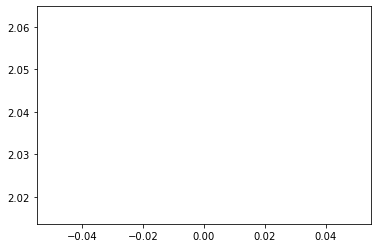

Epoch 1/19
----------
train Loss: 1.9397 Acc: 0.6083 Correct: 73.0
val Loss: 1.9193 Acc: 0.7375 Correct: 236.0


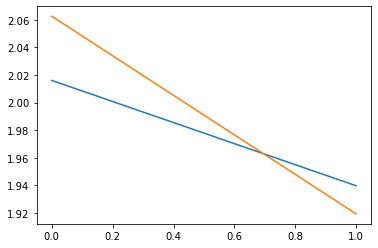

Epoch 2/19
----------
train Loss: 1.9050 Acc: 0.7000 Correct: 84.0
val Loss: 1.8458 Acc: 0.7625 Correct: 244.0


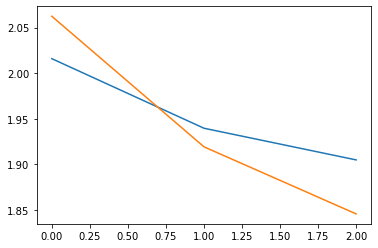

Epoch 3/19
----------
train Loss: 1.9064 Acc: 0.7083 Correct: 85.0
val Loss: 1.8133 Acc: 0.7469 Correct: 239.0


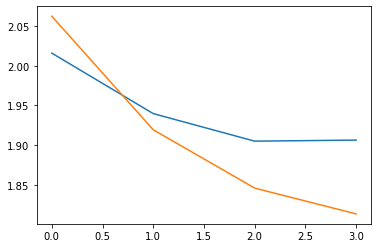

Epoch 4/19
----------
train Loss: 1.8830 Acc: 0.7417 Correct: 89.0
val Loss: 1.8165 Acc: 0.7688 Correct: 246.0


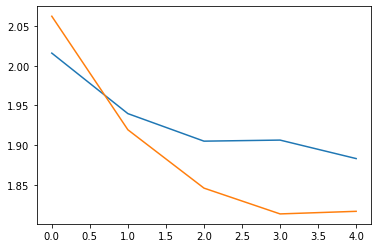

Epoch 5/19
----------
train Loss: 1.8735 Acc: 0.7583 Correct: 91.0
val Loss: 1.8058 Acc: 0.8000 Correct: 256.0


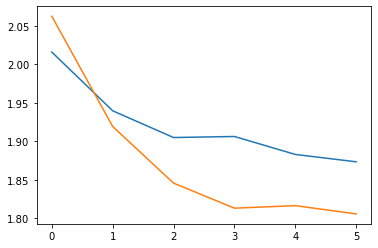

Epoch 6/19
----------
train Loss: 1.8599 Acc: 0.8167 Correct: 98.0
val Loss: 1.7828 Acc: 0.8063 Correct: 258.0


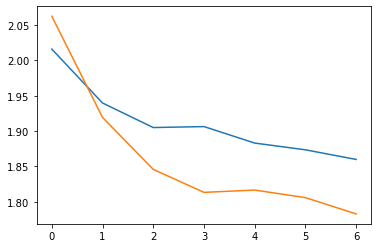

Epoch 7/19
----------
train Loss: 1.8517 Acc: 0.7750 Correct: 93.0
val Loss: 1.7816 Acc: 0.7844 Correct: 251.0


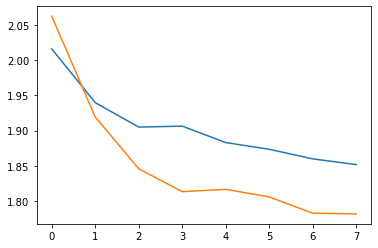

Epoch 8/19
----------
train Loss: 1.8439 Acc: 0.7333 Correct: 88.0
val Loss: 1.7869 Acc: 0.7906 Correct: 253.0


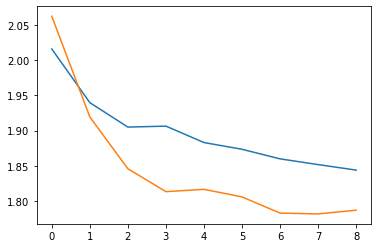

Epoch 9/19
----------
train Loss: 1.8404 Acc: 0.7583 Correct: 91.0
val Loss: 1.7764 Acc: 0.8094 Correct: 259.0


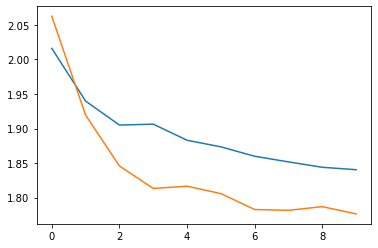

Epoch 10/19
----------
train Loss: 1.8208 Acc: 0.7583 Correct: 91.0
val Loss: 1.7707 Acc: 0.8063 Correct: 258.0


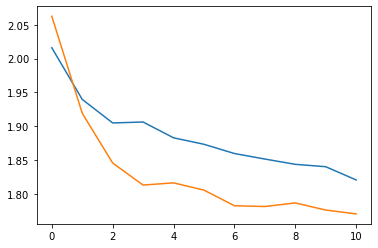

Epoch 11/19
----------
train Loss: 1.8111 Acc: 0.8083 Correct: 97.0
val Loss: 1.7764 Acc: 0.8281 Correct: 265.0


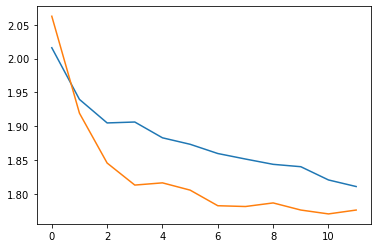

Epoch 12/19
----------
train Loss: 1.8101 Acc: 0.8167 Correct: 98.0
val Loss: 1.7803 Acc: 0.8187 Correct: 262.0


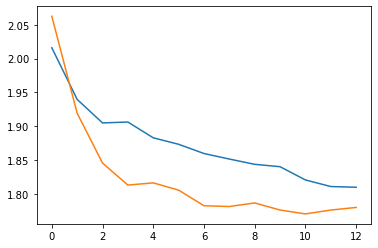

Epoch 13/19
----------
train Loss: 1.8002 Acc: 0.8417 Correct: 101.0
val Loss: 1.7854 Acc: 0.8219 Correct: 263.0


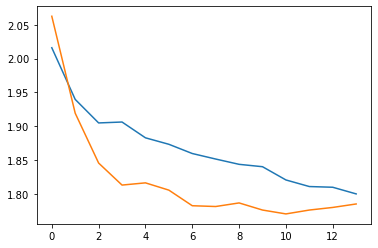

Epoch 14/19
----------
train Loss: 1.8106 Acc: 0.8000 Correct: 96.0
val Loss: 1.7547 Acc: 0.8156 Correct: 261.0


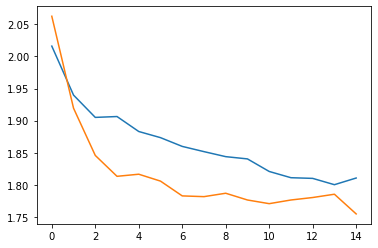

Epoch 15/19
----------
train Loss: 1.7934 Acc: 0.8083 Correct: 97.0
val Loss: 1.7627 Acc: 0.8156 Correct: 261.0


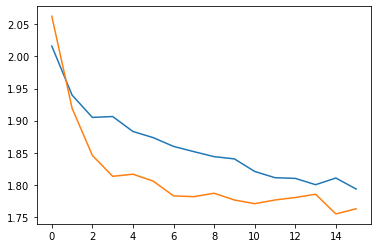

Epoch 16/19
----------
train Loss: 1.8081 Acc: 0.8167 Correct: 98.0
val Loss: 1.7563 Acc: 0.8063 Correct: 258.0


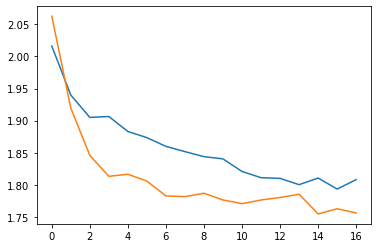

Epoch 17/19
----------
train Loss: 1.8007 Acc: 0.8250 Correct: 99.0
val Loss: 1.7681 Acc: 0.8125 Correct: 260.0


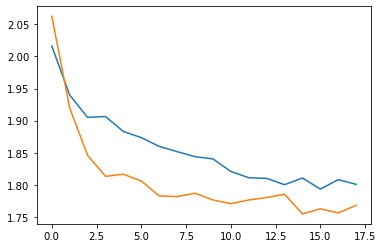

Epoch 18/19
----------
train Loss: 1.8049 Acc: 0.8250 Correct: 99.0
val Loss: 1.7554 Acc: 0.8125 Correct: 260.0


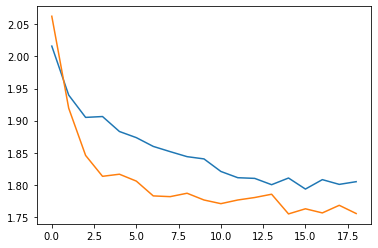

Epoch 19/19
----------
train Loss: 1.7896 Acc: 0.8500 Correct: 102.0
val Loss: 1.7869 Acc: 0.8094 Correct: 259.0


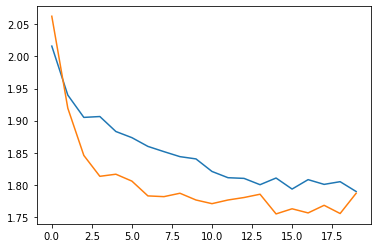

Training complete in 37m 44s
Best val Acc: 0.828125


XCM(
  (cnn_layers_1): Sequential(
    (conv_11): Conv2d(1, 16, kernel_size=(125, 125), stride=(1, 1), padding=(62, 62))
    (batchnorm_11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_11): ReLU(inplace=True)
    (conv_12): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
    (relu_12): ReLU(inplace=True)
    (squeeze_12): Squeeze()
    (swap_12): SwapLastDim()
  )
  (cnn_layers_2): Sequential(
    (view_21): View(3, 315)
    (conv_21): Conv1d(3, 16, kernel_size=(125,), stride=(1,), padding=(62,))
    (batchnorm_21): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_21): ReLU(inplace=True)
    (conv_22): Conv1d(16, 1, kernel_size=(1,), stride=(1,))
    (relu_22): ReLU(inplace=True)
  )
  (cnn_layers_3): Sequential(
    (swap_31): SwapLastDim()
    (conv_31): Conv1d(315, 32, kernel_size=(125,), stride=(1,), padding=(62,))
    (batchnorm_31): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_r

In [23]:
# model = XCM(93, X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
model = net1
criterion = nn.CrossEntropyLoss()
# optimizer_ft = torch.optim.Adam(model.parameters(), lr=4.5e-4)
optimizer_ft = torch.optim.Adam(model.parameters(), lr=1.5e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, datasets_size, 20)

## Feature Extraction

In [24]:
feature_maps = CAMFeatureMaps(GradCAM)
feature_maps.load(model,model.cnn_layers_3,'conv_3')
mask = {}
for i in range(len(np.unique(y_test))):
    mask[i] = feature_maps.show(X_test[0], i)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [16, 1, 125, 125], but got 3-dimensional input of size [1, 3, 315] instead

In [ ]:
net1.cnn_layers_3

In [ ]:
mask = feature_maps.show(X_test[0], None)

In [ ]:
map_activation_to_input(X_test[0], mask, 1e3)

In [ ]:
feature_maps = CAMFeatureMaps(GradCAMPlusPlus)
feature_maps.load(model, 'relu_3')
mask1 = {}
for i in range(len(np.unique(y_test))):
    mask1[i] = feature_maps.show(X_test[0], i)

In [ ]:
mask1 = feature_maps.show(X_test[0], None)

In [ ]:
map_activation_to_input(X_test[0], mask1, 1)

In [ ]:
len(torch.zeros((4,1,2,3)).squeeze().size())